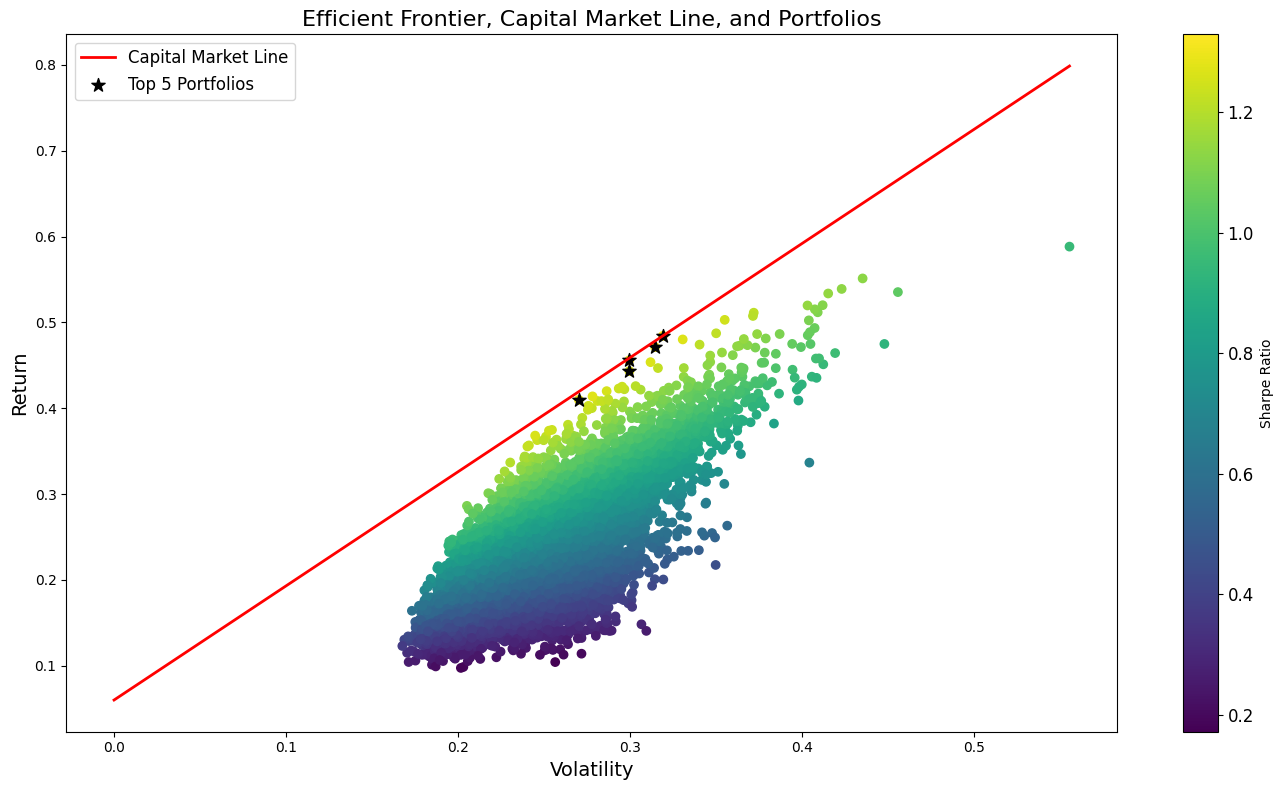

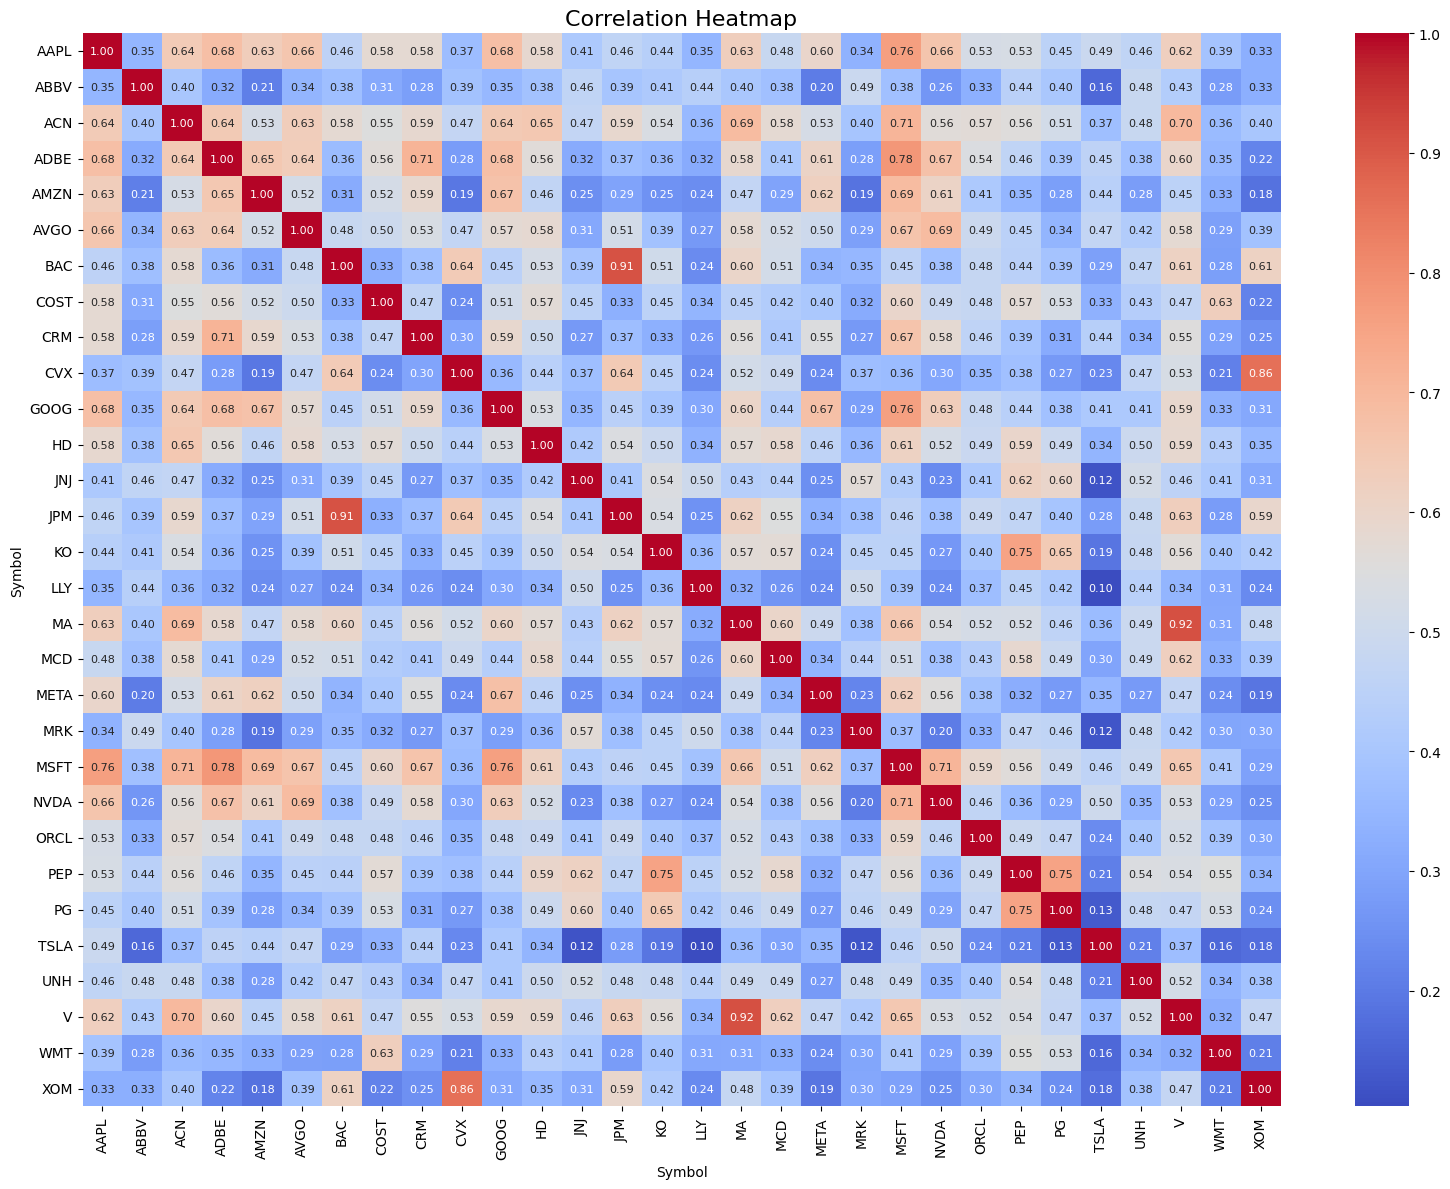

Top 5 Most Profitable Portfolios Based on Sharpe Ratio:
                      Symbols                                  Weights   Return  Volatility  Sharpe Ratio
 [JNJ, NVDA, LLY, TSLA, AVGO]  [5.69%, 37.39%, 34.33%, 11.28%, 11.32%] 0.484387    0.319218      1.329456
    [HD, TSLA, MA, NVDA, LLY]  [7.17%, 17.84%, 11.86%, 24.69%, 38.44%] 0.455885    0.299612      1.321329
  [TSLA, PG, NVDA, AAPL, LLY]  [26.14%, 20.43%, 26.28%, 3.41%, 23.74%] 0.471281    0.314674      1.307005
[LLY, TSLA, AVGO, AAPL, ORCL]  [37.91%, 15.42%, 10.97%, 32.09%, 3.62%] 0.409755    0.270305      1.293928
  [LLY, TSLA, PG, NVDA, AAPL] [25.26%, 28.34%, 17.14%, 10.66%, 18.60%] 0.443256    0.299711      1.278751


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Load the data
file_path = "master_data.csv"
data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# Calculate daily returns for each stock
daily_returns = data.pivot(columns='Symbol', values='Adj Close').pct_change()
daily_returns = daily_returns.dropna()

# Define constants
INVESTMENT = 1e7  # INR 1 Crore
MAX_WEIGHT = 0.3  # Maximum exposure in a single stock
NUM_STOCKS = 5    # Number of stocks in the portfolio
RISK_FREE_RATE = 0.06  # Assuming a risk-free rate of 6%

# Function to generate random portfolios
def generate_random_portfolios(num_portfolios: int) -> pd.DataFrame:
    portfolio_returns = []
    portfolio_volatilities = []
    portfolio_weights = []
    portfolio_symbols = []

    for _ in range(num_portfolios):
        selected_stocks = np.random.choice(daily_returns.columns, NUM_STOCKS, replace=False)
        weights = np.random.random(NUM_STOCKS)
        weights /= np.sum(weights)
        annualized_return = np.sum(daily_returns[selected_stocks].mean() * weights) * 252
        annualized_volatility = np.sqrt(np.dot(weights.T, np.dot(daily_returns[selected_stocks].cov() * 252, weights)))
        portfolio_returns.append(annualized_return)
        portfolio_volatilities.append(annualized_volatility)
        portfolio_weights.append(weights)
        portfolio_symbols.append(selected_stocks)

    portfolios = pd.DataFrame({
        'Return': portfolio_returns,
        'Volatility': portfolio_volatilities,
        'Weights': portfolio_weights,
        'Symbols': portfolio_symbols
    })
    portfolios['Sharpe Ratio'] = (portfolios['Return'] - RISK_FREE_RATE) / portfolios['Volatility']

    return portfolios

# Function to calculate Sharpe Ratio using divide and conquer
def calculate_sharpe_ratio_in_chunks(portfolios, chunk_size=1000):
    num_chunks = len(portfolios) // chunk_size + (1 if len(portfolios) % chunk_size else 0)
    for i in range(num_chunks):
        start_index = i * chunk_size
        end_index = start_index + chunk_size
        portfolios_chunk = portfolios.iloc[start_index:end_index]
        portfolios.loc[start_index:end_index, 'Sharpe Ratio'] = (portfolios_chunk['Return'] - RISK_FREE_RATE) / portfolios_chunk['Volatility']
    return portfolios

# Generate random portfolios
num_portfolios = 10000
portfolios = generate_random_portfolios(num_portfolios)

# Calculate Sharpe Ratio in chunks
portfolios = calculate_sharpe_ratio_in_chunks(portfolios)

# Plot Efficient Frontier, Capital Market Line, and Scatter Plot of Portfolios
plt.figure(figsize=(14, 8))
plt.scatter(portfolios['Volatility'], portfolios['Return'], c=portfolios['Sharpe Ratio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio').ax.tick_params(labelsize=12)
plt.xlabel('Volatility', fontsize=14)
plt.ylabel('Return', fontsize=14)
plt.title('Efficient Frontier, Capital Market Line, and Portfolios', fontsize=16)

# Capital Market Line
cml_slope = (portfolios['Return'] - RISK_FREE_RATE) / portfolios['Volatility']
CML_x = np.linspace(0, max(portfolios['Volatility']), 200)
CML_y = RISK_FREE_RATE + cml_slope.max() * CML_x
plt.plot(CML_x, CML_y, color='red', linewidth=2, label='Capital Market Line')

# Highlight the top 5 most profitable portfolios based on Sharpe Ratio
top_portfolios = portfolios.nlargest(5, 'Sharpe Ratio')
plt.scatter(top_portfolios['Volatility'], top_portfolios['Return'], color='black', marker='*', s=100, label='Top 5 Portfolios')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(daily_returns.corr(), annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Display top 5 most profitable portfolios based on Sharpe Ratio
top_portfolios = portfolios.nlargest(5, 'Sharpe Ratio')
top_portfolios['Weights'] = top_portfolios['Weights'].apply(lambda weights: ['{:.2%}'.format(w) for w in weights])
top_portfolios = top_portfolios.sort_values(by='Sharpe Ratio', ascending=False)

# Display the top portfolios in a nice output
print("Top 5 Most Profitable Portfolios Based on Sharpe Ratio:")
print(top_portfolios[['Symbols', 'Weights', 'Return', 'Volatility', 'Sharpe Ratio']].to_string(index=False))
